In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import collections
import lightning as pl
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import Logger
from statsmodels.tsa.arima.model import ARIMA

In [5]:
!git clone https://github.com/magarthur/Mines.git

Cloning into 'Mines'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 27 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 1.92 MiB | 12.84 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [6]:
import os
os.listdir("Mines")

['RNN_Classification.ipynb',
 'TP_Neural_Networks.pdf',
 'RNN_seriestemporelles3.ipynb',
 'bike_daily.csv',
 'RNN_Analyse_exploratoire.ipynb',
 'RNN_seriestemporelles.ipynb',
 '.git',
 'data_propre.csv',
 'README.md']

In [7]:
# On affiche les 5 premières lignes du dataset
df = pd.read_csv('Mines/data_propre.csv')
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [10]:
#Importation et analyse
df['dteday'] = pd.to_datetime(df['dteday'])
df = df.sort_values('dteday')

I. Visualisation et prise en main du dataset

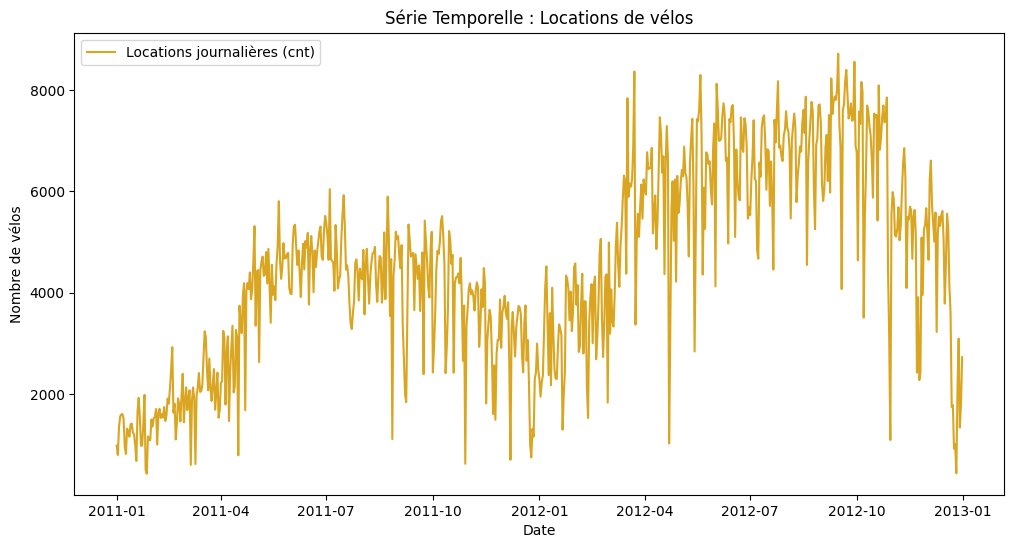

In [9]:
#Visualisation
plt.figure(figsize=(12, 6))
plt.plot(df['dteday'], df['cnt'], c="goldenrod", label="Locations journalières (cnt)")
plt.title("Série Temporelle : Locations de vélos")
plt.xlabel("Date")
plt.ylabel("Nombre de vélos")
plt.legend()
plt.show()

2. Traitement des variables d'entrée

In [11]:
#ONE-HOT ENCODING
seasons_one_hot = pd.get_dummies(df['season'], prefix='season')

# Encodage de la Météo (weathersit : 1, 2, 3)
weather_one_hot = pd.get_dummies(df['weathersit'], prefix='weather')

#Variables déjà binaires
binary_features = df[['workingday', 'holiday']]

# 4. Cible (cnt) et Normalisation
# On veut prédire 'cnt', mais on l'utilise aussi en entrée (on pourrait d'ailleurs n'utiliser que 'cnt' en entrée, cela reviendrait à étudier une série temporelle comme dans l'UP2)
scaler = MinMaxScaler(feature_range=(0, 1))
cnt_scaled = scaler.fit_transform(df['cnt'].values.reshape(-1, 1))
cnt_series = pd.DataFrame(cnt_scaled, columns=['cnt_scaled'])

#  CONCATÉNATION DE TOUTES LES ENTRÉES
# On assemble tout dans un seul DataFrame pour l'entraînement
features_df = pd.concat([cnt_series, seasons_one_hot, weather_one_hot, binary_features], axis=1)

#On évite le type 'object' ou 'bool' en remplaçant par qqch que numpy peut lire
features_df = features_df.astype('float32')

# Conversion en numpy pour le fenêtrage
data_multivariate = features_df.values
target_data = cnt_scaled # Ce qu'on veut prédire

print("Variables utilisées :")
print(features_df.columns.tolist())
print(f"Nombre total de features en entrée : {data_multivariate.shape[1]}")

Variables utilisées :
['cnt_scaled', 'season_1', 'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3', 'workingday', 'holiday']
Nombre total de features en entrée : 10


In [12]:
# Paramètres
window_length = 2  # Comme demandé dans l'énoncé
batch_size = 16

4. Création des windows length

In [13]:
# Création des Sliding Window
samples = []
targets = []

for i in range(len(data_multivariate) - window_length):
    # L'entrée est une séquence de longueur 'window_length' (2 en l'occurence)
    sample = data_multivariate[i : i + window_length]
    # La cible est la valeur juste après (avec i et i-1 on prédit i+1)
    outcome = target_data[i + window_length]
    samples.append(sample)
    targets.append(outcome)

samples = np.array(samples)
targets = np.array(targets)

3. Séparation train/test (80/20)

In [14]:
# Train/test split
train_size = int(len(samples) * 0.8)

x_train = samples[:train_size]
y_train = targets[:train_size]
x_test = samples[train_size:]
y_test = targets[train_size:]

print("x_train shape:", x_train.shape)
print("x_test shape :", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

# Converst to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Création des DataLoaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

x_train shape: (583, 2, 10)
x_test shape : (146, 2, 10)
y_train shape: (583, 1)
y_test shape : (146, 1)


5. Choix et entraînement d'un modèle de réseau récurrent

In [15]:
class RNNModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, dense1, dense2, dense3):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            nonlinearity="relu",
        )
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(hidden_size, dense1)
        self.fc2 = nn.Linear(dense1, dense2)
        self.fc3 = nn.Linear(dense2, dense3)
        self.out = nn.Linear(dense3, 1) # Sortie de dimension 1 (prédiction de 'cnt' à i+1)
        self.relu = nn.ReLU()
        self.criterion = nn.MSELoss()
        self.save_hyperparameters()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.dropout(self.relu(self.fc1(out)))
        out = self.dropout(self.relu(self.fc2(out)))
        out = self.dropout(self.relu(self.fc3(out)))
        out = self.out(out)
        return out

    def training_step(self, batch, batch_idx):
        input_seq, prediction = batch
        outputs = self(input_seq)
        loss = self.criterion(outputs, prediction)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_seq, prediction = batch
        outputs = self(input_seq)
        loss = self.criterion(outputs, prediction)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return [optimizer]

# Instanciation du modèle
nb_features = x_train.shape[2]
model = RNNModel(input_size=nb_features, hidden_size=64, dense1=64, dense2=16, dense3=16)
print(model)

RNNModel(
  (rnn): RNN(10, 64, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (criterion): MSELoss()
)


In [17]:
# Callback pour sauvegarder le meilleur modèle
checkpoint_callback = ModelCheckpoint(
    save_top_k=1, monitor="val_loss", mode="min", verbose=True
)

trainer = pl.Trainer(
    max_epochs=50, #On n'utilise pas SimpleLogger parce que je n'ai pas réussi à l'importer même avec !pip...
    enable_checkpointing=True,
    check_val_every_n_epoch=1,
    callbacks=[checkpoint_callback],
)

# Lancement de l'entraînement
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type    ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ rnn       │ RNN     │  4.9 K │ train │     0 │
│ 1 │ dropout   │ Dropout │      0 │ train │     0 │
│ 2 │ fc1       │ Linear  │  4.2 K │ train │     0 │
│ 3 │ fc2       │ Linear  │  1.0 K │ train │     0 │
│ 4 │ fc3       │ Linear  │    272 │ train │     0 │
│ 5 │ out       │ Linear  │     17 │ train │     0 │
│ 6 │ relu      │ ReLU    │      0 │ train │     0 │
│ 7 │ criterion │ MSELoss │      0 │ train │     0 │
└───┴───────────┴─────────┴────────┴───────┴───────┘

Trainable params: 10.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 10.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size 
(torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to 
incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:317: The number of training batches 
(37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size 
(torch.Size([7, 1, 1])) that is different to the input size (torch.Size([7, 1])). This will likely lead to 
incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size 
(torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to 
incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)

INFO: Epoch 0, global step 37: 'val_loss' reached 0.29216 (best 0.29216), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=37.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 37: 'val_loss' reached 0.29216 (best 0.29216), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=37.ckpt' as top 1
INFO: Epoch 1, global step 74: 'val_loss' reached 0.05908 (best 0.05908), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=74.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 74: 'val_loss' reached 0.05908 (best 0.05908), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=74.ckpt' as top 1
INFO: Epoch 2, global step 111: 'val_loss' reached 0.04545 (best 0.04545), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=2-step=111.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 111: 'val_loss' reac

6. Choix faits, et statistiques durant l'entrainement


Les choix faits sur la structure du réseau :

couche 0 : RNN
couche 1 : Dropout (pour éviter que le modèle apprenne par coeur le "Train" et soit sur-entraîné)
couches 2, 3 et 4 : reprise de l'architecture fournie dans les codes python que vous nous avez donnés, avec respectivement 64, 16 et 16 neurones
couche 5 : sortie

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Démarrage de l'entraînement...


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type    ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ rnn       │ RNN     │  4.9 K │ train │     0 │
│ 1 │ dropout   │ Dropout │      0 │ train │     0 │
│ 2 │ fc1       │ Linear  │  4.2 K │ train │     0 │
│ 3 │ fc2       │ Linear  │  1.0 K │ train │     0 │
│ 4 │ fc3       │ Linear  │    272 │ train │     0 │
│ 5 │ out       │ Linear  │     17 │ train │     0 │
│ 6 │ relu      │ ReLU    │      0 │ train │     0 │
│ 7 │ criterion │ MSELoss │      0 │ train │     0 │
└───┴───────────┴─────────┴────────┴───────┴───────┘

Trainable params: 10.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 10.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size 
(torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to 
incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:317: The number of training batches 
(37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size 
(torch.Size([7, 1, 1])) that is different to the input size (torch.Size([7, 1])). This will likely lead to 
incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size 
(torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to 
incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)

INFO: Epoch 0, global step 37: 'val_loss' reached 0.02998 (best 0.02998), saving model to '/content/SimpleLogger/0.1/checkpoints/epoch=0-step=37.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 37: 'val_loss' reached 0.02998 (best 0.02998), saving model to '/content/SimpleLogger/0.1/checkpoints/epoch=0-step=37.ckpt' as top 1
INFO: Epoch 1, global step 74: 'val_loss' reached 0.02856 (best 0.02856), saving model to '/content/SimpleLogger/0.1/checkpoints/epoch=1-step=74.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 74: 'val_loss' reached 0.02856 (best 0.02856), saving model to '/content/SimpleLogger/0.1/checkpoints/epoch=1-step=74.ckpt' as top 1
INFO: Epoch 2, global step 111: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 111: 'val_loss' was not in top 1
INFO: Epoch 3, global step 148: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 148: 

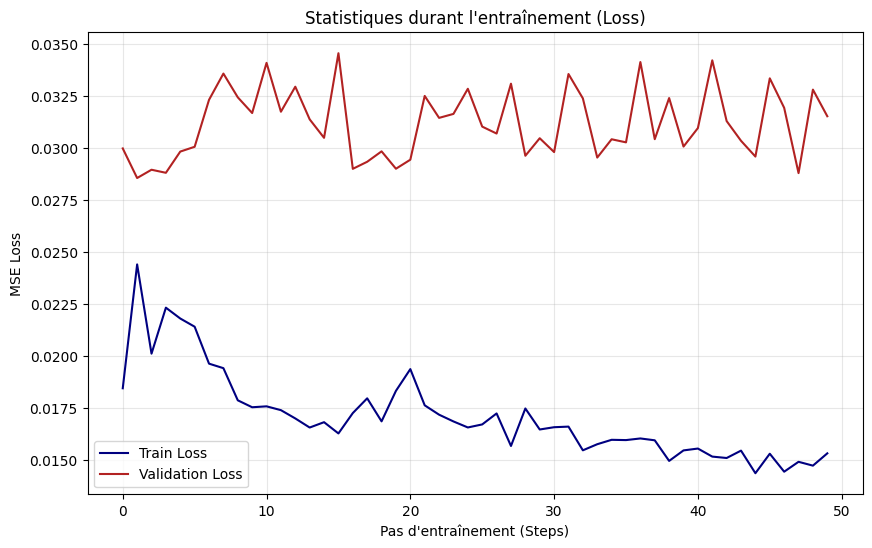

In [19]:
class SimpleLogger(Logger):
    def __init__(self):
        super().__init__()
        self.metrics = collections.defaultdict(list)

    @property
    def name(self):
        return "SimpleLogger"

    @property
    def version(self):
        return "0.1"

    def log_hyperparams(self, params):
        pass

    def log_metrics(self, metrics, step):
        # On stocke chaque métrique
        for k, v in metrics.items():
            # Conversion tenseur -> nombre
            if isinstance(v, torch.Tensor):
                v = v.item()
            self.metrics[k].append(v)

    def save(self):
        pass

    def finalize(self, status):
        pass

logger = SimpleLogger()

# Callbacks
checkpoint_callback = pl.pytorch.callbacks.ModelCheckpoint(
    save_top_k=1, monitor="val_loss", mode="min", verbose=True
)

# Trainer
trainer = pl.Trainer(
    max_epochs=50,
    logger=logger,
    enable_checkpointing=True,
    check_val_every_n_epoch=1,
    callbacks=[checkpoint_callback],
)

print("Démarrage de l'entraînement...")
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

# Affichage du Graphique
plt.figure(figsize=(10, 6))

# Récupération des clés
train_key = next((k for k in logger.metrics.keys() if "train_loss" in k), None)
val_key = next((k for k in logger.metrics.keys() if "val_loss" in k), None)

if train_key:
    # On filtre les valeurs None s'il y en a
    train_data = [x for x in logger.metrics[train_key] if x is not None]
    plt.plot(train_data, label="Train Loss", color='navy')

if val_key:
    # Les validations sont moins fréquentes, on les plotte simplement
    val_data = [x for x in logger.metrics[val_key] if x is not None]
    plt.plot(val_data, label="Validation Loss", color='firebrick')

plt.legend()
plt.title("Statistiques durant l'entraînement (Loss)")
plt.xlabel("Pas d'entraînement (Steps)")
plt.ylabel("MSE Loss")
plt.grid(True, alpha=0.3)
plt.show()

On analyse la LossCurve ci-dessus:
- Le train loss ne diverge pas, ce qui est bon signe
- Le train loss semble avoir une tendance à diminuer, ce qui est un bon signe aussi
- En revanche, la validation loss est nettement supérieure au train loss et ne semble ni diminuer, ni converger. Cela peut être un signe de léger surapprentissage -> on aurait tendance à trop généraliser avec ce modèle.

Ce surapprentissage restant léger, on poursuit le TP avec ce modèle.

Par ailleurs, la RMSE du modèle est de 1177,77, ce qui semble énorme comparé aux valeurs de 'cnt', mais on voit ensuite que la courbe des prédictions suit plutôt bien la courbe réelle.

7. Performances du modèle, analyse et interprétations

In [20]:
# Chargement du meilleur modèle
best_model = RNNModel.load_from_checkpoint(
    checkpoint_path=checkpoint_callback.best_model_path
)
best_model.eval()

RNNModel(
  (rnn): RNN(10, 64, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (criterion): MSELoss()
)

Commentaire : en faisant la méthode Hotones sur les variables d'entrée, on ne passe que d'une RMSE de 1196 à 1178 (par rapport à RNN avec simplement 'cnt' comment entrée).

RMSE Train: 1042.66
RMSE Test: 1175.64


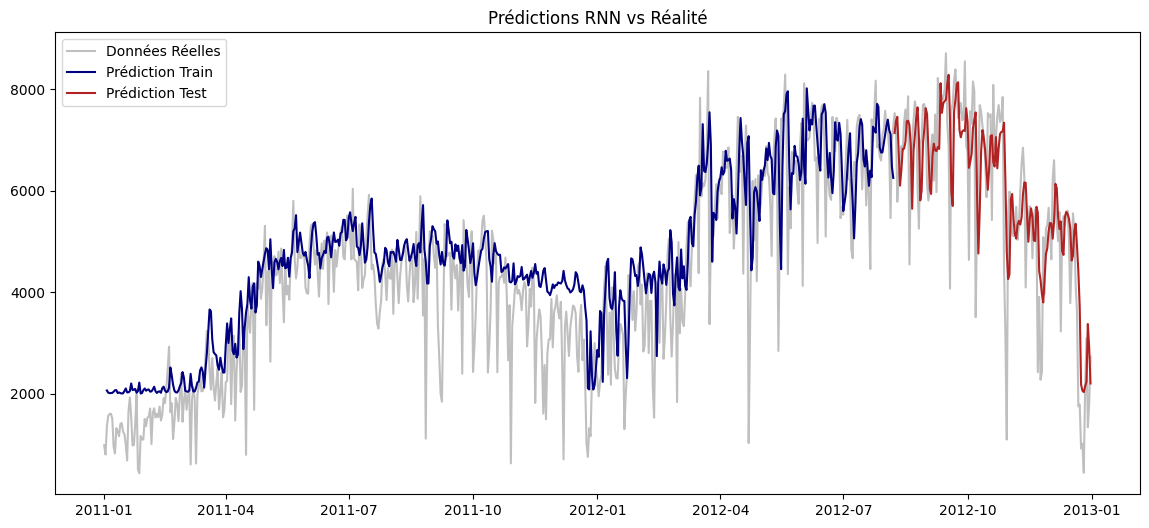

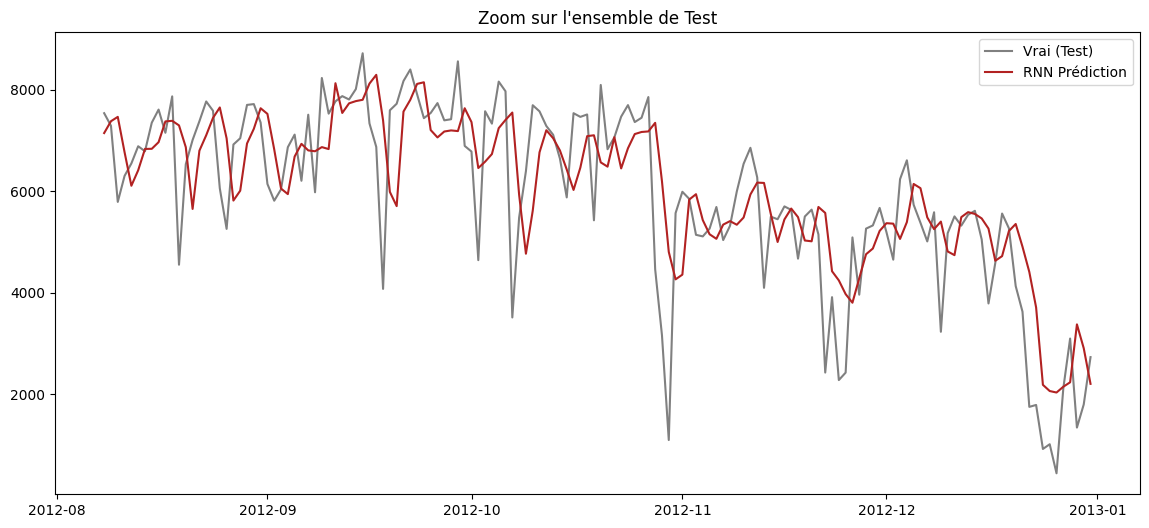

In [22]:
# Prédictions
with torch.no_grad():
    train_preds_scaled = best_model(x_train_tensor).cpu().numpy()
    test_preds_scaled = best_model(x_test_tensor).cpu().numpy()

# Inversion de la normalisation (pour revenir aux vraies valeurs de cnt)
train_preds = scaler.inverse_transform(train_preds_scaled)
y_train_true = scaler.inverse_transform(y_train)
test_preds = scaler.inverse_transform(test_preds_scaled)
y_test_true = scaler.inverse_transform(y_test)

# Calcul des métriques
rmse_train = np.sqrt(mean_squared_error(y_train_true, train_preds))
rmse_test = np.sqrt(mean_squared_error(y_test_true, test_preds))

print(f"RMSE Train: {rmse_train:.2f}")
print(f"RMSE Test: {rmse_test:.2f}")

# Visualisation Graphique
train_dates = df['dteday'].iloc[window_length : window_length + len(train_preds)]
test_dates = df['dteday'].iloc[window_length + len(train_preds) : ]

plt.figure(figsize=(14, 6))
plt.plot(df['dteday'], df['cnt'], color='gray', alpha=0.5, label='Données Réelles')

# Prédictions Train
plt.plot(train_dates, train_preds, color='navy', label='Prédiction Train')

# Prédictions Test
plt.plot(test_dates, test_preds, color='firebrick', label='Prédiction Test')

plt.title("Prédictions RNN vs Réalité")
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_true, label="Vrai (Test)", color='gray')
plt.plot(test_dates, test_preds, label="RNN Prédiction", color='firebrick')
plt.title("Zoom sur l'ensemble de Test")
plt.legend()
plt.show()

8. Comparaison avec ARIMA

RMSE ARIMA (Aligné): 1957.16


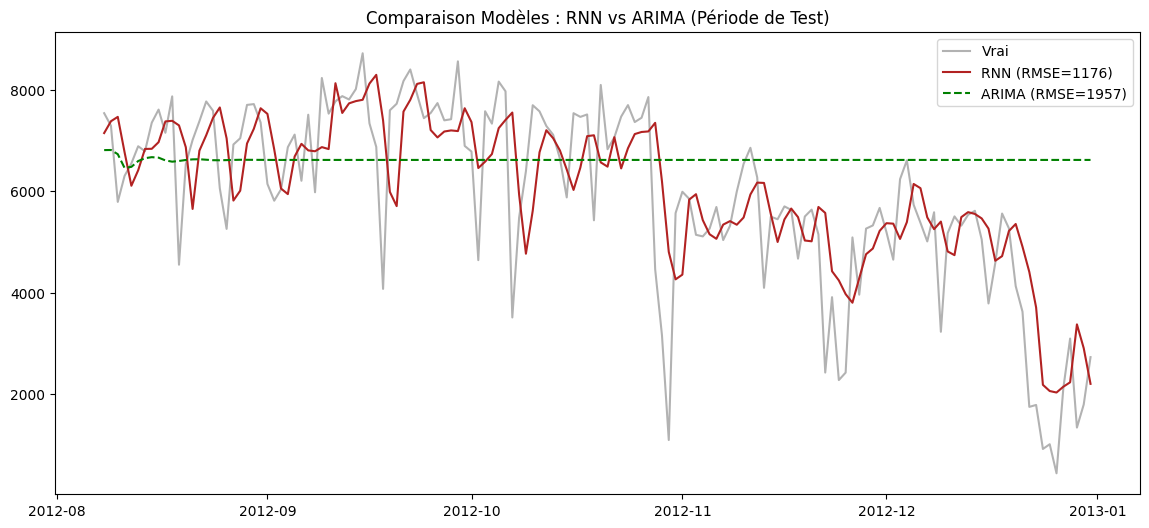

In [24]:
# On entraîne ARIMA uniquement sur le train
train_arima = df['cnt'].iloc[:train_size].values
test_arima = df['cnt'].iloc[train_size:].values

# Création et entraînement du modèle ARIMA
model_arima = ARIMA(train_arima, order=(6,1,0))
model_fit = model_arima.fit()

# Prédiction sur la longueur brute du test
forecast_arima = model_fit.forecast(steps=len(test_arima))

# On aligne ARIMA sur le RNN en supprimant les 2 premières valeurs (window_length)
test_arima_aligned = test_arima[window_length:]
forecast_arima_aligned = forecast_arima[window_length:]

# Recalcul du RMSE sur la période commune exacte
rmse_arima = np.sqrt(mean_squared_error(test_arima_aligned, forecast_arima_aligned))
print(f"RMSE ARIMA (Aligné): {rmse_arima:.2f}")

# Visualisation
plt.figure(figsize=(14, 6))
# On utilise test_arima_aligned pour que les tailles correspondent à test_dates
plt.plot(test_dates, test_arima_aligned, label="Vrai", color='gray', alpha=0.6)
plt.plot(test_dates, test_preds, label=f"RNN (RMSE={rmse_test:.0f})", color='firebrick')
plt.plot(test_dates, forecast_arima_aligned, label=f"ARIMA (RMSE={rmse_arima:.0f})", color='green', linestyle='--')

plt.title("Comparaison Modèles : RNN vs ARIMA (Période de Test)")
plt.legend()
plt.show()
plt.show()

Problème : la prédiction ARIMA tend vers qqch de constant. En effet elle ne se base que sur le jour J pour prédire le jour J+1. Cela fonctionne au début, puis petit à petit ARIMA utilise ses propres prédictions pour prédire la suite, d'où un retour vers la moyenne. On essaye de corriger cela dans le code suivant :

RMSE ARIMA (Rolling): 1143.93


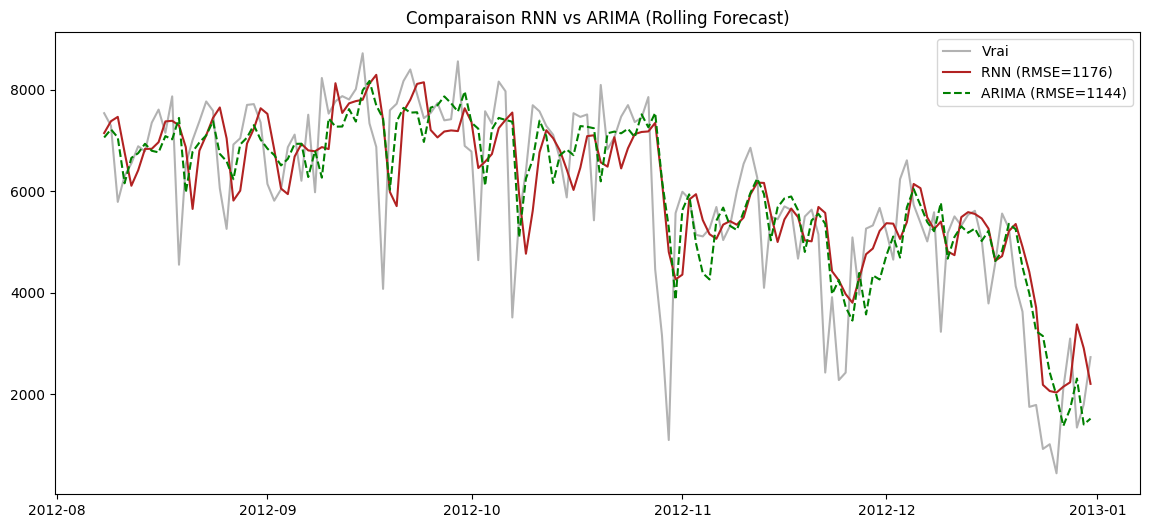

In [25]:
# On utilise ARIMA d'une autre façon
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Données d'entraînement initiales
history = [x for x in train_arima]
predictions_arima = []

# Boucle pas à pas sur le test set
for t in range(len(test_arima)):
    # On entraîne le modèle sur l'historique disponible
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()

    # On prédit le prochain pas (t+1)
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)

    # 3. On rajoute l'observation dans l'historique pour le tour suivant
    obs = test_arima[t]
    history.append(obs)

# On supprime toujours les 2 premieres valeurs ('window_length') pour avoir deux jeux de données de la même taille
test_arima_aligned = test_arima[window_length:]
forecast_arima_aligned = predictions_arima[window_length:]

# RMSE
rmse_arima = np.sqrt(mean_squared_error(test_arima_aligned, forecast_arima_aligned))
print(f"RMSE ARIMA (Rolling): {rmse_arima:.2f}")

# Visualisation comparative
plt.figure(figsize=(14, 6))
plt.plot(test_dates, test_arima_aligned, label="Vrai", color='gray', alpha=0.6)
plt.plot(test_dates, test_preds, label=f"RNN (RMSE={rmse_test:.0f})", color='firebrick')
plt.plot(test_dates, forecast_arima_aligned, label=f"ARIMA (RMSE={rmse_arima:.0f})", color='green', linestyle='--')

plt.title("Comparaison RNN vs ARIMA (Rolling Forecast)")
plt.legend()
plt.show()

9. Commentaires

La différence entre le modèle RNN, qui est l'objet de cette partie, et le modèla ARIMA, est que le modèle RNN est dit multivarié. Il utilise en entrée pluieurs paramètres, et peut donc prendre en compte la météo, le jour de la semaine (travaillé ou non), et toutes les données du dataset, ce qui semble à première vue une amélioration énorme par rapport à un ARIMA qui se contente juste d'étudier le modèle comme une série temporelle. Cependant, on constate que le modèle ARIMA a une meilleure performance que le modèle RNN. Comment expliquer cela ? En réalité, le nombre de vélos débloqués dépend tellement de la météo et du jour que ces dernières variables en deviennent inutiles. De plus, ce sont des variables avec une très forte saisonnalité, ce qui les rend facilement prévisible, et les informations qu'elles donnent sont déjà intégrées dans les informations données par l'historique de 'cnt'. Ensuite, le modèle ARIMA choisi était simplement plus efficace et correspondait mieux à notre jeu de données qu'un RNN.